In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfilt, tukey, detrend, filtfilt
from numpy.fft import fft2, fftfreq, fftshift, ifft2, ifftshift
from scipy.ndimage import gaussian_filter
from time import perf_counter
from datetime import datetime
import matplotlib.dates as mdates

In [2]:
path = "/data/fast1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
# file ="South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T195914Z.h5"
file ="South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T102614Z.h5"
f = h5py.File(path + file, 'r')
    
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [3]:
data.shape

(47500, 12000)

In [4]:
# Window the data
datads=data
# datads = data[5000:25000,3000:6000]

In [5]:
# Filter the data
b, a = butter(2, (14,45),'bp',fs=200)
# data_m = data - data.mean(axis=0, keepdims=True)
filt_data = filtfilt(b, a, datads ) # Also tried sosfilt
filt_data.shape

(47500, 12000)

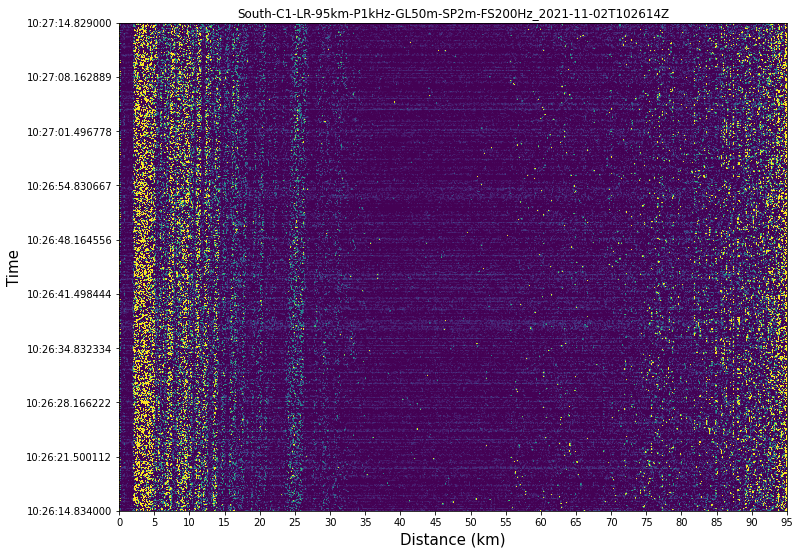

In [6]:
# Ploting
x_lims = list(map(datetime.utcfromtimestamp, [timestamp[0], timestamp[-1]]))
x_lims = mdates.date2num(x_lims)
y_lims = [0, 2*47.500]

fig, ax = plt.subplots(figsize = (10, 10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
ds=10
im = ax.imshow( np.transpose(filt_data[::ds,::ds]),
               extent = [y_lims[0], y_lims[1],
                      x_lims[0], x_lims[1]],
               aspect=1e5, vmin=0,vmax=1e3)
ax.yaxis_date()
plt.ylabel("Time", fontsize = 15)
plt.xlabel("Distance (km)", fontsize = 15)
date_format = mdates.DateFormatter('%H:%M:%S.%f')
ax.yaxis.set_major_formatter(date_format)   
# plt.xticks(rotation=15)
plt.yticks(np.linspace(x_lims[0], x_lims[1], 10))
plt.xticks(np.linspace(0, 2*47.5, 20))
plt.title(file.split('.')[0])
plt.show()

In [7]:
t0 = perf_counter()
data_fft = fft2(detrend(datads))
filt_data_fft = fft2(detrend(filt_data))
print(perf_counter()-t0)
print(data_fft.shape)

92.25334086176008
(47500, 12000)


In [8]:
# Make freq and wavenum vectors
nx = data_fft.shape[0]
ns = data_fft.shape[1]
f = fftshift(fftfreq(ns, d=1/200))
k = fftshift(fftfreq(nx, d=2))
ff,kk=np.meshgrid(f,k)

In [9]:
# Soundwaves have f/k = c so f = k*c
c=1480
g = 1.0*((ff < kk*c) & (ff < -kk*c))

c2 = c*2
g2 = 1.0*((ff < kk*c2) & (ff < -kk*c2))

g = g + np.fliplr(g)
g2 = g2 + np.fliplr(g2)

g = g-g2

g = gaussian_filter(g, 40)
# epsilon = 0.0001
# g = np.exp (-epsilon*( ff-kk*c)**2 )

g = (g - np.min(g.flatten())) / (np.max(g.flatten()) - np.min(g.flatten()))
print(g.shape)

(47500, 12000)


In [10]:
g = g.astype('f')

<ipython-input-11-4a17044de491>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f[::ds],k[::ds],g[::ds,::ds],vmin=0,vmax=1)


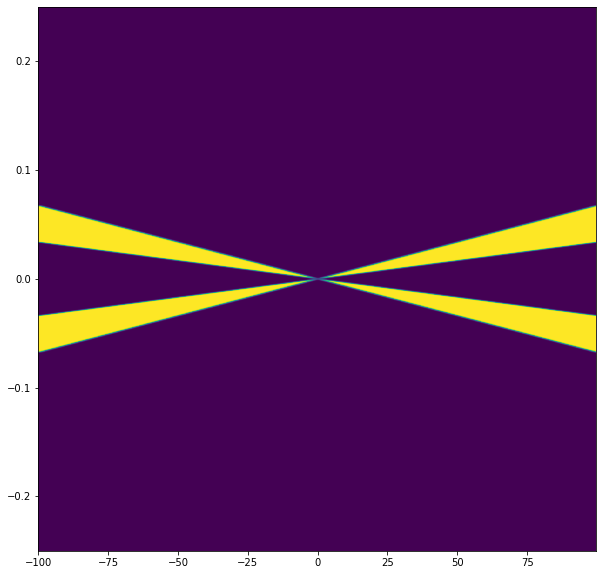

In [11]:
ds = 10
fig,ax=plt.subplots(figsize=(10,10))
fig.patch.set_facecolor('w')
plt.pcolormesh(f[::ds],k[::ds],g[::ds,::ds],vmin=0,vmax=1)
# plt.xlim([-5,5])
# plt.ylim([-0.05,0.05])
plt.show()

<ipython-input-12-5cfe8979e284>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=plt.pcolormesh(f[::ds],k[::ds],
<ipython-input-12-5cfe8979e284>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=plt.pcolormesh(f[::ds],k[::ds],


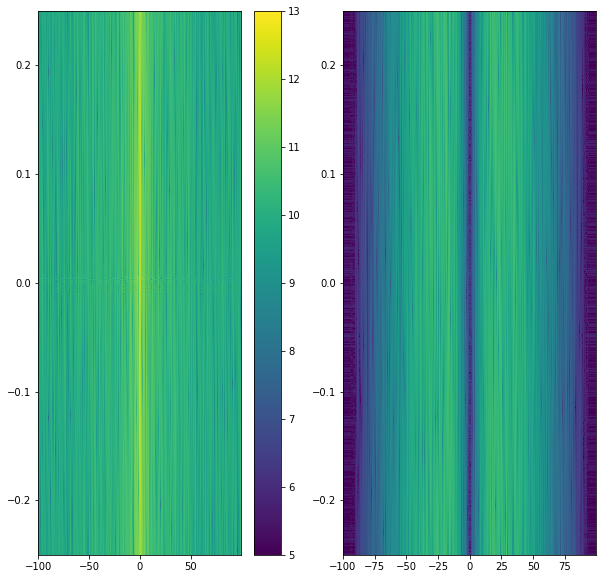

In [12]:
ds = 10
fig,ax=plt.subplots(figsize=(10,10))
fig.patch.set_facecolor('w')
plt.subplot(121)
c=plt.pcolormesh(f[::ds],k[::ds],
                 np.log10(np.abs(fftshift(data_fft[::ds,::ds]))),
                 vmin=5,vmax=13)
# plt.contour(f[::ds],k[::ds],g[::ds,::ds],linecolor='r',vmin=0,vmax=1)
plt.colorbar(c)
plt.subplot(122)
c=plt.pcolormesh(f[::ds],k[::ds],
                 np.log10(np.abs(fftshift(filt_data_fft[::ds,::ds]))),
                 vmin=5,vmax=13)
# plt.xlim([-5,5])
# plt.ylim([-0.05,0.05])
plt.show()

In [13]:
data_fft_g = fftshift(data_fft) * g
filt_data_fft_g = fftshift(filt_data_fft) * g

In [14]:
data_g = ifft2(ifftshift(data_fft_g))
filt_data_g = ifft2(ifftshift(filt_data_fft_g))

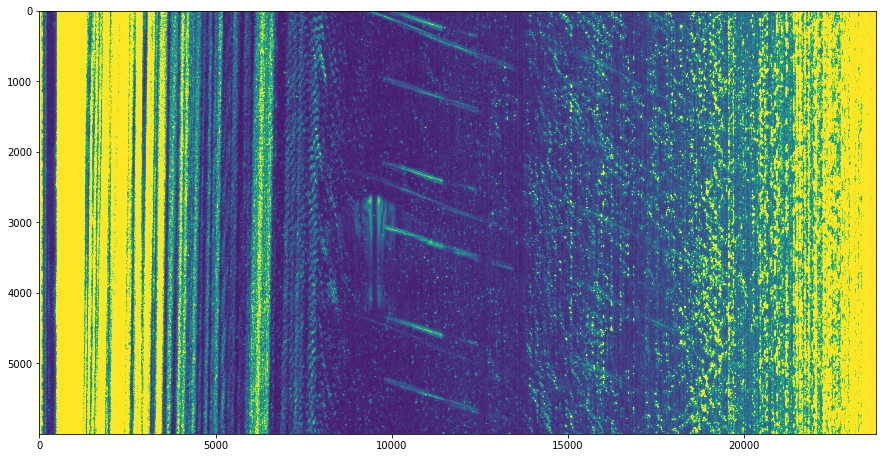

In [63]:
ds = 2
# abs_data_g = np.abs(data_g[::ds,::ds])
abs_filt_data_g = np.abs(filt_data_g[::ds,::ds])

fig,ax=plt.subplots(figsize=(15,10))
fig.patch.set_facecolor('w')
# plt.subplot(121)
plt.imshow( abs_filt_data_g.T , aspect=2, vmin=0, vmax=400)
# plt.subplot(122)
# plt.imshow( np.abs(filt_data[::ds,::ds]).T , aspect=4, 
#            vmin=0, vmax=200 )
# plt.xlim([9400,9700])
# plt.xlim([8000,11000])
# plt.plot((9525,9525),(0,6000),'--w')
# plt.plot((9650,9650),(0,6000),'--w')
plt.show()

<ipython-input-58-88a3dfde1350>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(t,f,np.log10(np.abs(sxx)),vmin = 3,vmax=5)
<ipython-input-58-88a3dfde1350>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(t,f,np.log10(np.abs(sxx)),vmin = 3,vmax=5)


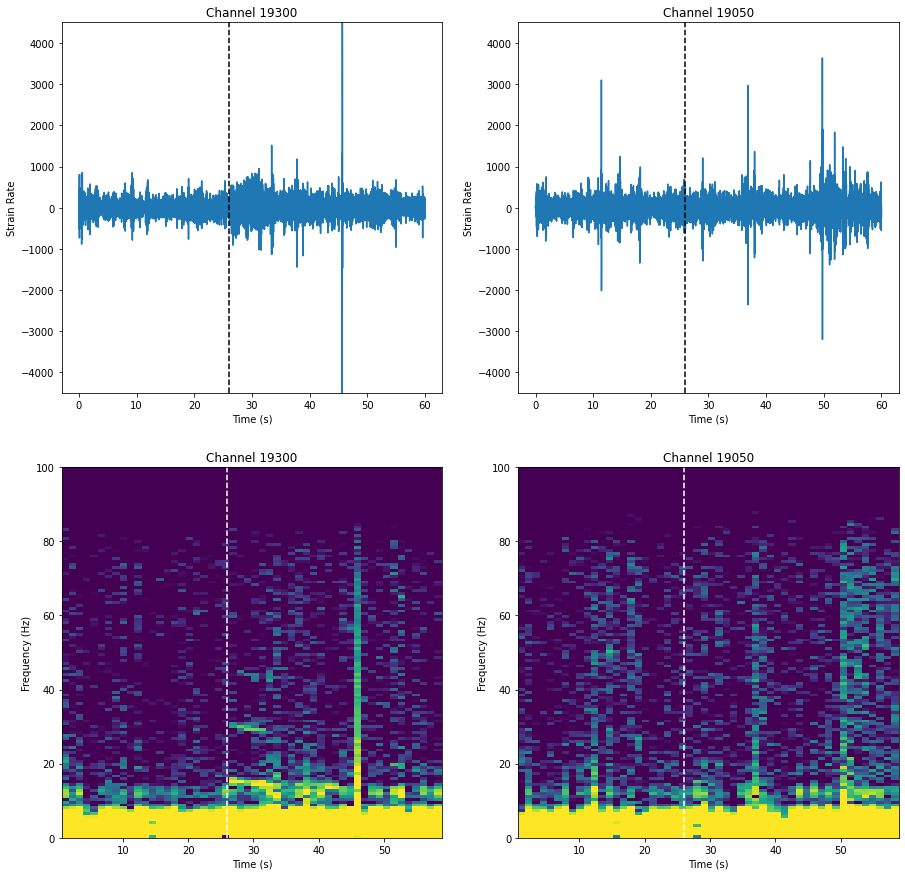

In [58]:
from scipy.signal import spectrogram
[b,a] = butter(2,(15,50),'bp',fs=200)
fig,ax =plt.subplots(2,2,figsize=(15,15))
fig.patch.set_facecolor('w')
for ind,chan in enumerate((19300,19050)):
    
    ax = plt.subplot(2,2,ind+1)
    trace_filt = filtfilt(b,a,data[chan,:])
    ax.plot(np.linspace(0,60,12000),trace_filt)
    ax.set_title('Channel %d'%chan)
    ax.set_ylim([-4500,4500])
    ax.plot((26,26),[-4500,4500],'--k')
    ax.set_ylabel('Strain Rate')
    ax.set_xlabel('Time (s)')
    
    f,t,sxx=spectrogram(data[chan,:],fs=200)
    ax = plt.subplot(2,2,ind+3)
    ax.set_title('Channel %d'%chan)
    ax.pcolor(t,f,np.log10(np.abs(sxx)),vmin = 3,vmax=5)
    ax.plot((26,26),(0,100),'--w')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')